<a href="https://colab.research.google.com/github/Nazer5130/ACP-HAFR/blob/main/ACP_HAFR_ACP344_10fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from numpy import linalg as la
from keras.utils import to_categorical

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import auc, roc_curve
import re
import pandas as pd

In [2]:
def load_seq_data(data_path,label):
  dataset = pd.read_csv(data_path,names=None,index_col=0, header=None)
  seq = []
  sample_count = 0

  for row in dataset.iterrows():
    if(row[0]!='>'):
      sample_count = sample_count +1
      array = [label, row[0]]
      name, sequence = array[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '', ''.join(array[1:]).upper())
      seq.append([name, sequence])

  print('# of ' + label + ' samples',sample_count)
  return seq

def prepare_feature_acp344():
    pos_all_seq_path = 'https://raw.githubusercontent.com/Shujaat123/ACP_LSE/main/dataset_acp_JTB_2014/1-s2.0-S0022519313004190-mmc1.txt'
    neg_all_seq_path = 'https://raw.githubusercontent.com/Shujaat123/ACP_LSE/main/dataset_acp_JTB_2014/1-s2.0-S0022519313004190-mmc2.txt'

    pos_all_seq = load_seq_data(pos_all_seq_path,'ACP')
    neg_all_seq = load_seq_data(neg_all_seq_path,'non-ACP')

    ALL_seq = pos_all_seq + neg_all_seq

    print(len(pos_all_seq), len(neg_all_seq), len(ALL_seq))
    return ALL_seq

In [3]:
def Isoelectric_Point(seq):
    AA = 'ACDEFGHIKLMNPQRSTVWY'
    x,y,z,w=1,2,4,8
    ip_val={
        'A':(6.11)*x  +(2.35)*y  +(9.87)*z,
        'C':(5.15)*x  +(1.92)*y  +(10.70)*z    +(8.37)*w,
        'D':(2.98)*x  +(1.99)*y  +(9.90)*z     +(3.90)*w,
        'E':(3.08)*x  +(2.1)*y   +(9.47)*z     +(4.07)*w,
        'F':(5.76)*x  +(2.2)*y   +(9.31)*z,
        'G':(6.06)*x  +(2.5)*y   +(9.78)*z,
        'H':(7.64)*x  +(1.8)*y   +(9.33)*z     +(6.04)*w,
        'I':(6.04)*x  +(2.32)*y  +(9.74)*z,
        'K':(9.47)*x  +(2.16)*y  +(9.06)*z     +(10.54)*w,
        'L':(6.04)*x  +(2.33)*y  +(9.74)*z,
        'M':(5.71)*x  +(2.13)*y  +(9.28)*z,
        'N':(5.43)*x  +(2.14)*y  +(8.72)*z,
        'P':(6.30)*x  +(1.95)*y  +(10.64)*z,
        'Q':(5.65)*x  +(2.17)*y  +(9.13)*z,
        'R':(10.76)*x +(1.82)*y  +(8.99)*z     +(12.48)*w,
        'S':(5.70)*x  +(2.19)*y  +(9.21)*z,
        'T':(5.60)*x  +(2.09)*y  +(9.10)*z,
        'V':(6.02)*x  +(2.29)*y  +(9.74)*z,
        'W':(5.88)*x  +(2.46)*y  +(9.76)*z,
        'Y':(5.63)*x  +(2.2)*y   +(9.21)*z     +(10.46)*w,
    }

    ip={}
    for aa1 in AA:
        ip[aa1] = 0
    sum=0
    for aa in seq:
        sum+=1
        ip[aa]+=ip_val[aa]

    ip_final=[]
    for aa in ip:
        ip_final.append(ip[aa]/sum)


    return ip_final

def Convert_Seq2CKSSCP(train_seq, gap1=8,gap2=4):
    cksscpfea = []
    seq_label = []
    ip_feature=[]
    for sseq in train_seq:
        temp= CKSSCP([sseq], gap1=gap1,gap2=gap2)
        cksscpfea.append(temp[1][1:])
        seq_label.append(sseq[0])
        ip_feature.append(Isoelectric_Point(sseq[1]))


    x = np.array(cksscpfea)
    y = np.array(seq_label)
    y[y=='ACP']=1
    y[y=='non-ACP']=0
    y = to_categorical(y)
    print('num pos:', sum(y[:,0]==1), 'num neg:', sum(y[:,0]==0))

    ip = np.array(ip_feature)
    x = np.concatenate((x, ip), axis=1)
    return x,y

def SC_feature(aPair,bPair):

    A1=['R','K','H']                    #amino acid with electrically charged side chain [positive]
    A2=['D','E']                        #amino acid with electrically charged side chain [negative]
    B=['S','T','N','Q']                 #amino acid with polar uncharged side chain
    C=['C','G','P']                     #amino acid with special cases
    D=['A','I','L','M','F','W','Y','V'] #amino acid with hydrophobic side chain


    if aPair in A1:
        A='1'
    elif aPair in A2:
        A='1'
    elif aPair in B:
        A='3'
    elif aPair in C:
        A='4'
    elif aPair in D:
        A='5'

    if bPair in A1:
        B='1'
    elif bPair in A2:
        B='1'
    elif bPair in B:
        B='3'
    elif bPair in C:
        B='4'
    elif bPair in D:
        B='5'

    return A,B

def Charge_feature(aPair,bPair):

    A1=['R','K','H']                    #amino acid with electrically charged side chain [positive]
    A2=['D','E']                        #amino acid with electrically charged side chain [negative]

    charge=0
    valid=0
    if aPair in A1:
        charge+=1
        valid+=1
    elif aPair in A2:
        charge-=1
        valid+=1

    if bPair in A1:
        charge+=1
        valid+=1
    elif bPair in A2:
        charge-=1
        valid+=1

    return charge, valid

def minSequenceLength(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(i[1]):
            minLen = len(i[1])
    return minLen

def CKSSCP(fastas, gap1=5,gap2=4, **kw):
    if gap1 < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap1+2:
        print('Error: all the sequence length should be larger than the (gap value) + 2 = ' + str(gap1+2) + '\n' + 'Current sequence length ='  + str(minSequenceLength(fastas)) + '\n\n')
        return 0

    if gap2 < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap2+2:
        print('Error: all the sequence length should be larger than the (gap value) + 2 = ' + str(gap2+2) + '\n' + 'Current sequence length ='  + str(minSequenceLength(fastas)) + '\n\n')
        return 0

    AA = 'ACDEFGHIKLMNPQRSTVWY'
    BB = '1345'
    CC = '12345'
    encodings = []
    bbPair = []
    ccPair = []

    for bb1 in BB:
        for bb2 in BB:
            bbPair.append(bb1 + bb2)
    for cc2 in CC:
        ccPair.append('1' + cc2 + 'C')
        ccPair.append('2' + cc2 + 'C')


    ccPair.append('3' + '1' + 'C')
    ccPair.append('3' + '2' + 'C')
    ccPair.append('4' + '1' + 'C')
    ccPair.append('4' + '2' + 'C')
    ccPair.append('5' + '1' + 'C')
    ccPair.append('5' + '2' + 'C')

    header = ['#']
    for g in range(gap1+1):
        for bb in bbPair:
            header.append(bb + '.gap' + str(g))

    for g in range(gap2+1):
        for cc in ccPair:
            header.append(cc + '.gap' + str(g))

    encodings.append(header)
    for i in fastas:
        name, sequence = i[0], i[1]
        code = [name]
        for g in range(gap1+1):
            myDict = {}
            for pair in bbPair:
                myDict[pair] = 0

            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    A,B=SC_feature(sequence[index1],sequence[index2])
                    myDict[A + B] = myDict[A + B]+1

                    sum = sum + 1
            for pair in bbPair:
                code.append(myDict[pair])# / sum)

        for g in range(gap2+1):
            myDict = {}
            ccPair_count = {}
            for pair in ccPair:
                myDict[pair] = 0
                ccPair_count[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    A,B=SC_feature(sequence[index1],sequence[index2])
                    charge,valid=Charge_feature(sequence[index1],sequence[index2])
                    if(valid>0):
                        myDict[A + B + 'C']+=charge
                        ccPair_count[A + B + 'C']+=1
                    sum = sum + 1
            for pair in ccPair:
                if(ccPair_count[pair]>0):
                    code.append(myDict[pair] / (sum*ccPair_count[pair]))
                else:
                    code.append(myDict[pair] / sum)

        encodings.append(code)
    return encodings

def TransDict_from_list(groups):
    transDict = dict()
    tar_list = ['0', '1', '2', '3', '4', '5', '6']
    result = {}
    index = 0
    for group in groups:
        g_members = sorted(group)  # Alphabetically sorted list
        for c in g_members:
            # print('c' + str(c))
            # print('g_members[0]' + str(g_members[0]))
            result[c] = str(tar_list[index])  # K:V map, use group's first letter as represent.
        index = index + 1
    return result

def get_3_protein_trids():
    nucle_com = []
    chars = ['0', '1', '2', '3', '4', '5', '6']
    base = len(chars)
    end = len(chars) ** 3
    for i in range(0, end):
        n = i
        ch0 = chars[n % base]
        n = n / base
        ch1 = chars[int(n % base)]
        n = n / base
        ch2 = chars[int(n % base)]
        nucle_com.append(ch0 + ch1 + ch2)
    return nucle_com

def translate_sequence(seq, TranslationDict):
    '''
    Given (seq) - a string/sequence to translate,
    Translates into a reduced alphabet, using a translation dict provided
    by the TransDict_from_list() method.
    Returns the string/sequence in the new, reduced alphabet.
    Remember - in Python string are immutable..

    '''
    import string
    from_list = []
    to_list = []
    for k, v in TranslationDict.items():
        from_list.append(k)
        to_list.append(v)
    # TRANS_seq = seq.translate(str.maketrans(zip(from_list,to_list)))
    TRANS_seq = seq.translate(str.maketrans(str(from_list), str(to_list)))
    # TRANS_seq = maketrans( TranslationDict, seq)
    return TRANS_seq

def get_4_nucleotide_composition(tris, seq, pythoncount=True):
    seq_len = len(seq)
    tri_feature = [0] * len(tris)
    k = len(tris[0])
    note_feature = [[0 for cols in range(len(seq) - k + 1)] for rows in range(len(tris))]
    if pythoncount:
        for val in tris:
            num = seq.count(val)
            tri_feature.append(float(num) / seq_len)
    else:
        # tmp_fea = [0] * len(tris)
        for x in range(len(seq) + 1 - k):
            kmer = seq[x:x + k]
            if kmer in tris:
                ind = tris.index(kmer)
                # tmp_fea[ind] = tmp_fea[ind] + 1
                note_feature[ind][x] = note_feature[ind][x] + 1
        # tri_feature = [float(val)/seq_len for val in tmp_fea]    #tri_feature type:list len:256
        u, s, v = la.svd(note_feature)
        for i in range(len(s)):
            tri_feature = tri_feature + u[i] * s[i] / seq_len
        # print tri_feature
        # pdb.set_trace()

    return tri_feature

def prepare_feature_acp344_2():
    label = []
    protein_seq_dict = {}
    groups = ['AGV', 'ILFP', 'YMTS', 'HNQW', 'RK', 'DE', 'C']
    group_dict = TransDict_from_list(groups)
    protein_tris = get_3_protein_trids()
    bpf=[]
    kmer=[]
    # get protein feature
    protein_seq_dict1 = prepare_feature_acp344()
    protein_seq_dict={}
    label=[]
    index=0
    for i,x in protein_seq_dict1:
        protein_seq_dict[index]=x
        if(i=='ACP'):
            label.append(1)
        else:
            label.append(0)
        index+=1


    for i in protein_seq_dict:  # and protein_fea_dict.has_key(protein) and RNA_fea_dict.has_key(RNA):
        protein_seq = translate_sequence(protein_seq_dict[i], group_dict)
        bpf_feature = BPF(protein_seq_dict[i])
        # print('bpf:',shape(bpf_feature))
        # pdb.set_trace()
        # RNA_tri_fea = get_4_nucleotide_composition(tris, RNA_seq, pythoncount=False)
        protein_tri_fea = get_4_nucleotide_composition(protein_tris, protein_seq, pythoncount =False)

        bpf.append(bpf_feature)
        kmer.append(protein_tri_fea)
        # protein_index = protein_index + 1
        # chem_fea.append(chem_tmp_fea)
    return np.array(bpf), np.array(kmer), label

def BPF(seq_temp):
    seq = seq_temp
    chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    fea = []
    tem_vec =[]
    k = 7
    for i in range(k):
        if seq[i] =='A':
            tem_vec = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='C':
            tem_vec = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='D':
            tem_vec = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='E':
            tem_vec = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='F':
            tem_vec = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='G':
            tem_vec = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='H':
            tem_vec = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='I':
            tem_vec = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='K':
            tem_vec = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='L':
            tem_vec = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='M':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
        elif seq[i]=='N':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
        elif seq[i]=='P':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
        elif seq[i]=='Q':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
        elif seq[i]=='R':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
        elif seq[i]=='S':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
        elif seq[i]=='T':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
        elif seq[i]=='V':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
        elif seq[i]=='W':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
        elif seq[i]=='Y':
            tem_vec = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
        fea = fea + tem_vec
    return fea

In [4]:
def calculate_performace(test_num, pred_y, labels):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp = tp + 1
            else:
                fn = fn + 1
        else:
            if labels[index] == pred_y[index]:
                tn = tn + 1
            else:
                fp = fp + 1

    acc = float(tp + tn) / test_num
    precision = float(tp) / (tp + fp)
    sensitivity = float(tp) / (tp + fn)
    specificity = float(tn) / (tn + fp)
    MCC = float(tp * tn - fp * fn) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    return acc, precision, sensitivity, specificity, MCC

def transfer_label_from_prob(proba):
    label = [1 if val >= 0.5 else 0 for val in proba]
    return label
def plot_roc_curve(labels, probality, legend_text, auc_tag=True):
    # fpr2, tpr2, thresholds = roc_curve(labels, pred_y)
    fpr, tpr, thresholds = roc_curve(labels, probality)  # probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    if auc_tag:
        rects1 = plt.plot(fpr, tpr, label=legend_text + ' (AUC=%6.3f) ' % roc_auc)
    else:
        rects1 = plt.plot(fpr, tpr, label=legend_text)

def yoden_index(y, y_pred):
  epsilon = 1e-30
  tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
  j = (tp/(tp + fn + epsilon)) + (tn/(tn+fp + epsilon)) - 1
  return j

def pmeasure(y, y_pred):
    epsilon = 1e-30
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    sensitivity = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    f1score = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return ({'Sensitivity': sensitivity, 'Specificity': specificity, 'F1-Score': f1score})

def Calculate_Stats(y_actual,y_pred):
  acc = accuracy_score(y_actual, y_pred)
  sen = pmeasure(y_actual, y_pred)['Sensitivity']
  spe = pmeasure(y_actual, y_pred)['Specificity']
  f1 = pmeasure(y_actual, y_pred)['F1-Score']
  mcc = matthews_corrcoef(y_actual, y_pred)
  bacc = balanced_accuracy_score(y_actual, y_pred)
  yi = yoden_index(y_actual, y_pred)
  return acc, sen, spe, f1, mcc, bacc, yi

# of ACP samples 138
# of non-ACP samples 206
138 206 344
num pos: 206 num neg: 138
# of ACP samples 138
# of non-ACP samples 206
138 206 344
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm1 (LSTM)                (None, 128)               389120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 full_connect (Dense)        (None, 1)                 129       
                                                                 
 activation_10 (Activation)  (None, 1)                 0         
                                                                 
Total params: 389249 (1.48 MB)
Trainable params: 389249 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Compili

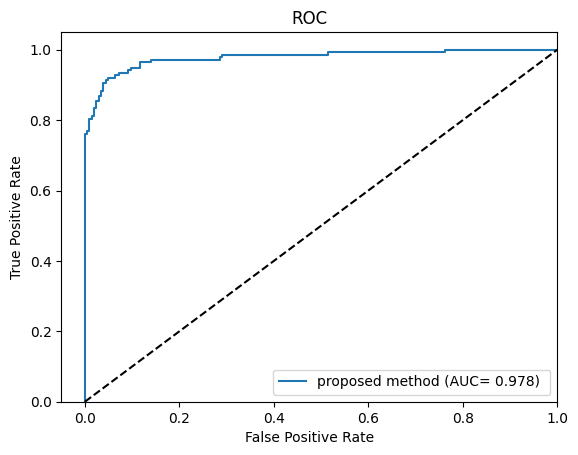

In [6]:
def ACP_DL(gap1=4,gap2=4):
    # define parameters
    timesteps = 1
    batch_size = 32
    epochs = 30

    # get data
    [DataX, LabelY] = Convert_Seq2CKSSCP(prepare_feature_acp344(), gap1=gap1,gap2=gap2)
    bpf, kmer, label = prepare_feature_acp344_2()
    #label = to_categorical(label)
    X = np.concatenate((bpf, kmer), axis=1) # k-mer with binary
    X = np.concatenate((X, DataX), axis=1)  # add side chain
    data_dim = len(X[0])
    #  expected input data shape: (batch_size, timesteps, data_dim)
    X = np.reshape(X, (len(X), timesteps, data_dim))

    stats = []

    num_cross_val = 10  # 10-fold
    all_labels = []
    all_prob = {}
    all_prob[0] = []

    for fold in range(num_cross_val):
        train = np.array([x for i, x in enumerate(X) if i % num_cross_val != fold])
        test = np.array([x for i, x in enumerate(X) if i % num_cross_val == fold])
        train_label = np.array([x for i, x in enumerate(label) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(label) if i % num_cross_val == fold])
        real_labels = []
        for val in test_label:
            if val == 1:
                real_labels.append(1)
            else:
                real_labels.append(0)

        train_label_new = []
        for val in train_label:
            if val == 1:
                train_label_new.append(1)
            else:
                train_label_new.append(0)
        all_labels = all_labels + real_labels

        model = Sequential()
        model.add(LSTM(128, return_sequences=False,input_shape=(timesteps, data_dim), name='lstm1'))  # returns a sequence of vectors of dimension 32
        model.add(Dropout(0.25, name='dropout'))
        model.add(Dense(1, name='full_connect'))
        model.add(Activation('sigmoid'))
        model.summary()

        print('Compiling the Model...')
        model.compile(loss='binary_crossentropy',  #
              optimizer='adam',
              metrics=['accuracy'])

        print("Train...")

        model.fit(train, train_label, batch_size=batch_size,epochs=epochs, verbose=0)

        lstm_proba = model.predict(test)
        all_prob[0] = all_prob[0] + [val for val in lstm_proba]
        y_pred_xgb = transfer_label_from_prob(lstm_proba)

        t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(test_label,y_pred_xgb)
        stats.append([t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1])

        print(t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1)
        print('---' * 30)

    mean_stat={}
    mean_stat['Sn']=np.mean(stats,axis=0)[0]
    mean_stat['Sp']=np.mean(stats,axis=0)[1]
    mean_stat['Acc']=np.mean(stats,axis=0)[2]
    mean_stat['Bal.Acc.']=np.mean(stats,axis=0)[3]
    mean_stat['MCC']=np.mean(stats,axis=0)[4]
    mean_stat['YI']=np.mean(stats,axis=0)[5]
    mean_stat['F1-score']=np.mean(stats,axis=0)[6]
    print('Mean stats:')
    print(mean_stat)

    std_stat={}
    std_stat['Sn']=np.std(stats,axis=0)[0]
    std_stat['Sp']=np.std(stats,axis=0)[1]
    std_stat['Acc']=np.std(stats,axis=0)[2]
    std_stat['Bal.Acc.']=np.std(stats,axis=0)[3]
    std_stat['MCC']=np.std(stats,axis=0)[4]
    std_stat['YI']=np.std(stats,axis=0)[5]
    std_stat['F1-score']=np.std(stats,axis=0)[6]
    print('\nStd stats:')
    print(std_stat)
    print('---' * 30)

    '''
    print('Mean stats:')
    print(np.mean(stats,axis=0))
    print('Std stats:')
    print(np.std(stats,axis=0))
    '''
    plot_roc_curve(all_labels, all_prob[0], 'proposed method')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    #plt.savefig( f'{i}' +' plot.jpg')
    plt.show()
    plt.close()


ACP_DL(gap1=1,gap2=5)